In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from copy import deepcopy
from tqdm import notebook, tqdm
import lightgbm as lgb

from sklearn.model_selection import GridSearchCV, ParameterGrid, cross_val_score, cross_validate
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [143]:
pd.options.display.expand_frame_repr = False
pd.set_option('display.max_columns', None)

Data
- Row – (int)
- Registration – (int) client ID
- Zipcode – (int)
- Age – (int)
- Partner_company – (0/1)
- Friend_promo – (0/1)
- Contract_period – (int)
- Lifetime – (int)
- Class_registration_weekly – (ﬂoat) average weekly visits
- Avg_additional_charges_total – (ﬂoat)
- Cancellation_freq – (ﬂoat) (ﬂoat)
- Exited – (0/1)

In [94]:
data = pd.read_csv('gym_data.csv', index_col=0)
print(data.info())
data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8100 entries, 10001 to 18100
Data columns (total 12 columns):
Registration                    8100 non-null int64
Zipcode                         8100 non-null int64
Age                             8100 non-null int64
Partner_company                 8100 non-null int64
Friend_promo                    8100 non-null int64
Contract_period                 8100 non-null int64
Lifetime                        8100 non-null int64
Class_registration_weekly       8100 non-null float64
Avg_additional_charges_total    8100 non-null float64
Cancellation_freq               8100 non-null float64
Exited                          8100 non-null int64
Unnamed: 12                     0 non-null float64
dtypes: float64(4), int64(8)
memory usage: 822.7 KB
None


,Registration,Zipcode,Age,Partner_company,Friend_promo,Contract_period,Lifetime,Class_registration_weekly,Avg_additional_charges_total,Cancellation_freq,Exited,Unnamed: 12
Row,,,,,,,,,,,,
10001,2000159,57328,37,0,1,6,10,1.06,134.200000,0.01,0,NaN
10002,2000235,29941,32,0,1,12,7,1.54,177.600000,0.07,0,NaN
10003,2000297,57328,29,0,1,6,5,2.15,205.000000,0.28,0,NaN
10004,2000435,29941,76,1,0,6,5,3.10,220.666667,0.39,0,NaN
10005,2000774,29941,24,1,0,1,3,1.00,142.040000,0.12,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
18096,2999305,57328,46,1,0,1,6,2.05,188.460000,0.07,0,NaN
18097,2999322,29941,22,0,1,12,2,1.59,226.333333,0.12,0,NaN
18098,2999324,29941,22,0,1,1,8,2.53,211.333333,0.00,0,NaN


In [95]:
data['Registration'].duplicated().sum()

0

In [96]:
data['Zipcode'].unique()

array([57328, 29941, 33726, 65232], dtype=int64)

In [97]:
data_exited = data.query('Exited==1')
data_exited

,Registration,Zipcode,Age,Partner_company,Friend_promo,Contract_period,Lifetime,Class_registration_weekly,Avg_additional_charges_total,Cancellation_freq,Exited,Unnamed: 12
Row,,,,,,,,,,,,
10005,2000774,29941,24,1,0,1,3,1.00,142.04,0.12,1,NaN
10006,2001211,29941,43,0,0,6,4,1.27,59.50,0.13,1,NaN
10007,2001427,29941,49,1,1,6,5,1.17,62.78,0.06,1,NaN
10011,2002162,29941,50,1,1,1,2,1.93,145.75,0.37,1,NaN
10014,2002496,29941,26,1,1,1,4,0.92,124.66,0.15,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
18071,2995870,29941,43,1,1,1,1,0.77,135.36,0.28,1,NaN
18076,2996850,29941,45,1,1,1,3,1.13,171.08,0.38,1,NaN
18081,2997301,29941,38,0,0,1,4,1.43,42.24,0.07,1,NaN


In [98]:
data_notexited = data.query('Exited==0')
data_notexited

,Registration,Zipcode,Age,Partner_company,Friend_promo,Contract_period,Lifetime,Class_registration_weekly,Avg_additional_charges_total,Cancellation_freq,Exited,Unnamed: 12
Row,,,,,,,,,,,,
10001,2000159,57328,37,0,1,6,10,1.06,134.200000,0.01,0,NaN
10002,2000235,29941,32,0,1,12,7,1.54,177.600000,0.07,0,NaN
10003,2000297,57328,29,0,1,6,5,2.15,205.000000,0.28,0,NaN
10004,2000435,29941,76,1,0,6,5,3.10,220.666667,0.39,0,NaN
10008,2001525,57328,38,0,1,1,5,0.35,188.333333,0.00,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
18096,2999305,57328,46,1,0,1,6,2.05,188.460000,0.07,0,NaN
18097,2999322,29941,22,0,1,12,2,1.59,226.333333,0.12,0,NaN
18098,2999324,29941,22,0,1,1,8,2.53,211.333333,0.00,0,NaN


## Analise

In [99]:
data.corr()

,Registration,Zipcode,Age,Partner_company,Friend_promo,Contract_period,Lifetime,Class_registration_weekly,Avg_additional_charges_total,Cancellation_freq,Exited,Unnamed: 12
Registration,1.000000,0.012945,0.014428,0.005111,-0.009231,0.004081,-0.005358,-0.002280,0.008094,-0.017310,-0.001464,NaN
Zipcode,0.012945,1.000000,-0.120193,0.001835,0.009833,0.082698,0.079364,0.119956,0.145650,-0.126776,-0.301095,NaN
Age,0.014428,-0.120193,1.000000,0.001319,0.015340,-0.077715,-0.116899,-0.128960,-0.229965,0.162721,0.373492,NaN
Partner_company,0.005111,0.001835,0.001319,1.000000,-0.411229,-0.001470,0.011820,0.007755,0.019319,0.001991,-0.011876,NaN
Friend_promo,-0.009231,0.009833,0.015340,-0.411229,1.000000,0.000475,-0.014500,0.000154,0.034762,-0.025547,-0.021422,NaN
Contract_period,0.004081,0.082698,-0.077715,-0.001470,0.000475,1.000000,0.076211,0.092774,0.100585,-0.115249,-0.254760,NaN
Lifetime,-0.005358,0.079364,-0.116899,0.011820,-0.014500,0.076211,1.000000,0.096470,0.161282,-0.124104,-0.296143,NaN
Class_registration_weekly,-0.002280,0.119956,-0.128960,0.007755,0.000154,0.092774,0.096470,1.000000,0.213975,0.300244,-0.380576,NaN
Avg_additional_charges_total,0.008094,0.145650,-0.229965,0.019319,0.034762,0.100585,0.161282,0.213975,1.000000,-0.171120,-0.541993,NaN
Cancellation_freq,-0.017310,-0.126776,0.162721,0.001991,-0.025547,-0.115249,-0.124104,0.300244,-0.171120,1.000000,0.438545,NaN


In [100]:
def compare_hists(col):
    data_exited[col].hist(alpha=0.7, density=True, label='Exited')
    data_notexited[col].hist(alpha=0.7, density=True, label='Not exited')
    plt.legend()
    plt.title(col)
    plt.show()


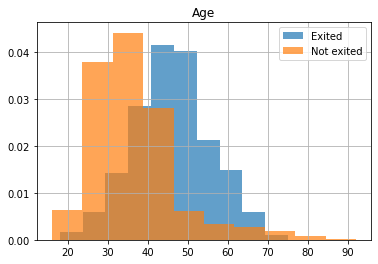

In [101]:
compare_hists('Age')

## Preparing

In [155]:
def upsample(features, target):
    
    counts = target.value_counts()
    val_most = counts.index[0]
    val_least = counts.index[1]
    repeat = int(np.round(counts[0]/counts[1],0))
    
    target_most = target[target == val_most]
    features_most = features[target == val_most]
    target_least = target[target == val_least]
    features_least = features[target == val_least]
    
    features_upsampled = pd.concat([features_most] + [features_least] * repeat)
    target_upsampled = pd.concat([target_most] + [target_least] * repeat)
    
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [156]:
def downsample(train_features, train_target):

    # расчет имеющегося соотношения признаков
    counts = train_target.value_counts()
    val_most = counts.index[0]
    val_least = counts.index[1]
    fraction = counts[1]/counts[0]
    
    # разделение обучающей выборки по целевому признаку
    train_target_most = train_target[train_target == val_most]
    train_features_most = train_features[train_target == val_most]
    train_target_least = train_target[train_target == val_least]
    train_features_least = train_features[train_target == val_least]

    # downsample обучающей выборки, чтобы сбалансировать признак
    train_features_downsampled = pd.concat([train_features_most.sample(frac=fraction, random_state=12345)] 
                                           + [train_features_least])
    train_target_downsampled = pd.concat([train_target_most.sample(frac=fraction, random_state=12345)] 
                                         + [train_target_least])
    train_features_downsampled, train_target_downsampled = shuffle(train_features_downsampled, 
                                                                   train_target_downsampled, random_state=12345)    

    return train_features_downsampled, train_target_downsampled

In [112]:
def train_valid_folds(features, target, folds=5):
    '''
    подготовка набора обучающих и валидационных выборок для кросс-валидации
    (чтобы экономить время в будущем)
    '''
    tt = []
    tf = []
    vt = []
    vf = []
    
    scaler = StandardScaler()
    kf = KFold(n_splits=folds)
    for train_index, valid_index in kf.split(target):
        
        cur_tt = target.iloc[train_index]
        cur_tf = features.iloc[train_index]
        cur_vt = target.iloc[valid_index]
        cur_vf = features.iloc[valid_index]
        
        # нормализация численных признаков
        cur_tf[num_cols] = scaler.fit_transform(cur_tf[num_cols])
        cur_vf[num_cols] = scaler.transform(cur_vf[num_cols])
        
        tt.append(cur_tt)
        tf.append(cur_tf)
        vt.append(cur_vt)
        vf.append(cur_vf)
        
    for i in range(folds):
        print('fold %d:' % i, tf[i].shape, tt[i].shape, vf[i].shape, vt[i].shape)
    return tf, tt, vf, vt

In [109]:
def plot_line2(x, y, y2, title='', xlabel='', ylabel=''):
    '''
    Функция выводит графики зависимости выбранных метрик исследуемой модели от значения гиперпараметра
    Входные параметры:
    - х - значения аргумента (гиперпараметра)
    - y - значения функции 1 (значения метрики на валидационной выборке)
    - y2 - значения функции 2 (значения метрики на обучающей выборке)
    - title - подпись графика (название модели)
    - xlabel - подпись оси Х (название изменяемого гиперпараметра)
    - ylabel - подпись оси Y
    '''
    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot(x, y, marker='.', label='valid')
    ax.plot(x, y2, marker='.', label='train')
    ax.grid()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [110]:
def plot_heatmap(x1, x2, y, title='', label=['','']):
    '''
    функция выводит график типа "heatmap" зависимости качества исследуемой модели от значений двух гиперпараметров
    х1 - значения гиперпараметра 1
    х2 - значения гиперпараметра 2
    y - значение метрики в виде одномерного массива (результат работы функции GridSearchCV.cv_results_['...'])
    title - название модели (подпись графика)
    label - массив с названиями двух гиперпараметров (подписи осей Х и Y)
    '''
    ysize = len(x1) if len(x1)<16 else 16
    xsize = len(x2) if len(x2)<16 else 16
    fig, ax = plt.subplots(figsize=(xsize,ysize))
    im = ax.imshow(y, cmap='coolwarm')
    plt.title(title)
    
    cax = fig.add_axes([ax.get_position().x1+0.05, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax)

    ax.set_xticks(np.arange(len(x2)))
    ax.set_yticks(np.arange(-0.5,len(x1)))
    ax.set_xticklabels(x2)
    ax.set_yticklabels(x1)
    ax.set_xlabel(label[1])
    ax.set_ylabel(label[0])

    for i in range(len(x1)):
        for j in range(len(x2)):
            text = ax.text(j, i, y[i, j], ha="center", va="center", color="k", fontsize=8)
    plt.show()

In [122]:
def paramCV(model, data, params={}, name=''):
    '''
    кастомная кросс-валидация с перебором параметров (аналог GridSearchCV)
    '''
    
    scoring = 'F1'
    
    # разбор data на набор X и y обучающей и валидационной выборок
    tf = data[0]
    tt = data[1]
    vf = data[2]
    vt = data[3]
    
    res = []
    res_train = []
    grid = ParameterGrid(params)
    pbar = notebook.tqdm(total=len(grid)*len(tf))
    
    # перебор сетки параметров
    for g in grid:
        model.set_params(**g)
        cv_res = []
        cv_res_train = []
        # перебор заранее созданного набора обучющих и валидационных выборок
        for i in range(len(tf)):
            model.fit(tf[i], tt[i])
            valid_predicted = model.predict(vf[i])
            cv_res.append(f1_score(vt[i], valid_predicted))
            train_predicted = model.predict(tf[i])
            cv_res_train.append(f1_score(tt[i], train_predicted))
            pbar.update() 
        res.append(np.round(np.mean(cv_res),3))
        res_train.append(np.round(np.mean(cv_res_train),3))
    pbar.close()
        
    # графики
    params_values = list(params.values())
    params_keys = list(params.keys())
    # линия для одного параметра
    if len(params_keys)==1:
        #plot_line(params_values[0], res, title=name, xlabel=params_keys[0], ylabel=scoring)
        plot_line2(params_values[0], res, res_train, title=name, xlabel=params_keys[0], ylabel=scoring)
    # тепловая карта для двух параметров
    elif len(params_keys)==2:
        len_p1 = len(params_values[0])
        len_p2 = len(params_values[1])
        res = np.reshape(res, (len_p1, len_p2))              
        plot_heatmap(params_values[0], params_values[1], res, title=name+' '+scoring, label=params_keys)
    elif len(params_keys)>2:
        print('grid_hparams: can\'t plot result')
    
    # отображение лучшего результата
    print('Best valid score:', np.max(res))
    print('Train score:', np.max(res_train))
    if len(params_keys) > 0:
        best_idx = np.argmax(res)
        print('Best params:', grid[best_idx])

    # запись лучшего результата в таблицу
    if name:
        result_table.loc[name,scoring] = np.max(res)

In [145]:
def print_feature_importance(model, features):
    '''
    вывод значимости признаков для деревянных моделей
    '''
    feature_importance = pd.DataFrame(index=features.columns)
    feature_importance['importance'] = model.feature_importances_
    print(feature_importance.sort_values('importance', ascending=False).round(3))

In [146]:
def print_lr_coefficients(model, features):
    '''
    вывод значимости признаков для логистической регрессии
    '''
    coefficients = pd.DataFrame(index=features.columns)
    coefficients['coef'] = model.coef_[0]
    coefficients['abs_coef'] = abs(coefficients['coef'])
    print(coefficients.sort_values('abs_coef', ascending=False).round(3))

## Training

In [125]:
y_train = data['Exited']
X_train = data.drop(['Exited', 'Unnamed: 12','Registration', 'Zipcode'], axis=1)

#cat_features = ['Zipcode','Partner_company','Friend_promo']
num_cols = ['Age','Contract_period', 'Lifetime', 'Class_registration_weekly',
                'Avg_additional_charges_total', 'Cancellation_freq']
#X[cat_features] = pd.get_dummies(X[cat_features], drop_first=True)

print('Features:', X_train.shape)
print('Target: ', y_train.shape)
X_train.head()

Фичи: (8100, 8)
Целевой признак:  (8100,)


,Age,Partner_company,Friend_promo,Contract_period,Lifetime,Class_registration_weekly,Avg_additional_charges_total,Cancellation_freq
Row,,,,,,,,
10001,37,0,1,6,10,1.06,134.200000,0.01
10002,32,0,1,12,7,1.54,177.600000,0.07
10003,29,0,1,6,5,2.15,205.000000,0.28
10004,76,1,0,6,5,3.10,220.666667,0.39
10005,24,1,0,1,3,1.00,142.040000,0.12


In [126]:
train_data = train_valid_folds(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

fold 0: (6480, 8) (6480,) (1620, 8) (1620,)
fold 1: (6480, 8) (6480,) (1620, 8) (1620,)
fold 2: (6480, 8) (6480,) (1620, 8) (1620,)
fold 3: (6480, 8) (6480,) (1620, 8) (1620,)
fold 4: (6480, 8) (6480,) (1620, 8) (1620,)


In [ ]:
train_data_upsampled = deepcopy(train_data)
for i in range(5):
    train_data_upsampled[0][i], train_data_upsampled[1][i] = upsample(train_data[0][i], train_data[1][i])
    print(train_data_upsampled[0][i].shape)

In [ ]:
train_data_downsampled = deepcopy(train_data)
for i in range(5):
    train_data_downsampled[0][i], train_data_downsampled[1][i] = downsample(train_data[0][i], train_data[1][i])
    print(train_data_downsampled[0][i].shape)

In [127]:
result_table = pd.DataFrame()

In [147]:
model = LogisticRegression(solver='lbfgs', random_state=123)
paramCV(model, train_data, name='LogisticRegression')
print_lr_coefficients(model, X_train)


Best valid score: 0.905
Train score: 0.907
                               coef  abs_coef
Class_registration_weekly    -3.131     3.131
Cancellation_freq             3.017     3.017
Avg_additional_charges_total -1.700     1.700
Lifetime                     -1.121     1.121
Age                           0.870     0.870
Contract_period              -0.714     0.714
Partner_company               0.178     0.178
Friend_promo                 -0.037     0.037


In [148]:
model = LogisticRegression(solver='lbfgs', random_state=123, class_weight='balanced')
paramCV(model, train_data, name='LogisticRegression balanced')
print_lr_coefficients(model, X_train)


Best valid score: 0.893
Train score: 0.895
                               coef  abs_coef
Class_registration_weekly    -3.037     3.037
Cancellation_freq             2.906     2.906
Avg_additional_charges_total -1.725     1.725
Lifetime                     -1.150     1.150
Age                           0.933     0.933
Contract_period              -0.776     0.776
Partner_company               0.242     0.242
Friend_promo                 -0.028     0.028


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefined

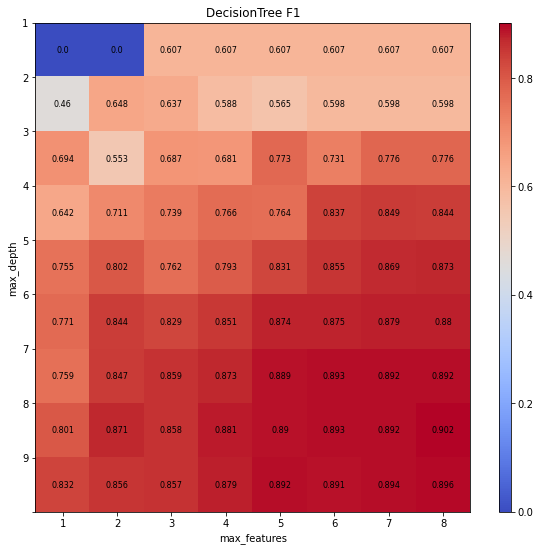

Best valid score: 0.902
Train score: 0.969
Best params: {'max_features': 8, 'max_depth': 8}
                              importance
Avg_additional_charges_total       0.301
Cancellation_freq                  0.273
Class_registration_weekly          0.225
Age                                0.112
Contract_period                    0.073
Lifetime                           0.015
Partner_company                    0.001
Friend_promo                       0.000


In [149]:
model = DecisionTreeClassifier(random_state=123)
params = {'max_depth': range(1,10), 'max_features': range(1,X_train.shape[1]+1)}
paramCV(model, train_data, params, name='DecisionTree')
print_feature_importance(model, X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefined

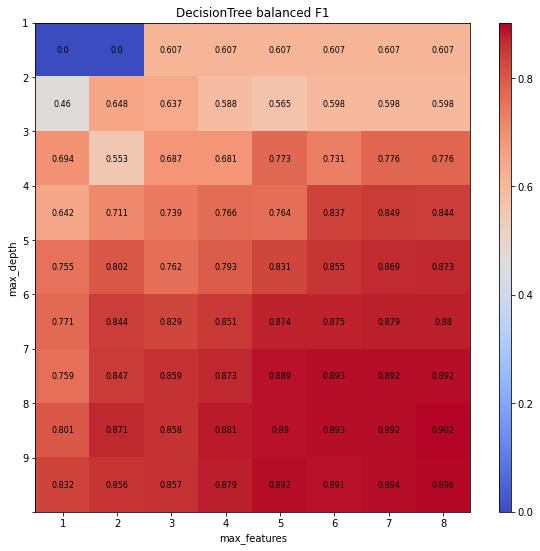

Best valid score: 0.902
Train score: 0.969
Best params: {'max_features': 8, 'max_depth': 8}
                              importance
Avg_additional_charges_total       0.301
Cancellation_freq                  0.273
Class_registration_weekly          0.225
Age                                0.112
Contract_period                    0.073
Lifetime                           0.015
Partner_company                    0.001
Friend_promo                       0.000


In [150]:
model = DecisionTreeClassifier(random_state=123)
params = {'max_depth': range(1,10), 'max_features': range(1,X_train.shape[1]+1)}
paramCV(model, train_data, params, name='DecisionTree balanced')
print_feature_importance(model, X_train)

In [152]:
model = RandomForestClassifier(random_state=123)
params = {'max_depth': range(1,12), 'max_features': range(1,X_train.shape[1]+1), 'n_estimators': [10,20,50,100]}
paramCV(model, train_data, params, name='RandomForest')
print_feature_importance(model, X_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefined

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: Undefined


grid_hparams: can't plot result
Best valid score: 0.951
Train score: 0.995
Best params: {'n_estimators': 100, 'max_features': 1, 'max_depth': 11}
                              importance
Avg_additional_charges_total       0.294
Cancellation_freq                  0.277
Class_registration_weekly          0.240
Age                                0.097
Contract_period                    0.051
Lifetime                           0.031
Partner_company                    0.005
Friend_promo                       0.004


In [153]:
model = RandomForestClassifier(random_state=123, class_weight='balanced')
params = {'max_depth': range(1,12), 'max_features': range(1,X_train.shape[1]+1), 'n_estimators': [10,20,50,100]}
paramCV(model, train_data, params, name='RandomForest')
print_feature_importance(model, X_train)


grid_hparams: can't plot result
Best valid score: 0.948
Train score: 0.998
Best params: {'n_estimators': 100, 'max_features': 1, 'max_depth': 9}
                              importance
Avg_additional_charges_total       0.334
Class_registration_weekly          0.219
Cancellation_freq                  0.207
Age                                0.121
Contract_period                    0.079
Lifetime                           0.032
Partner_company                    0.004
Friend_promo                       0.004


#### LGBM

In [154]:
model = lgb.LGBMClassifier(boosting_type='gbdt', random_state=123)
paramCV(model, train_data, name='LightGBM')
print_feature_importance(model, X_train)


Best valid score: 0.941
Train score: 0.998
                              importance
Class_registration_weekly            756
Cancellation_freq                    666
Avg_additional_charges_total         601
Age                                  427
Lifetime                             243
Contract_period                      130
Friend_promo                          92
Partner_company                       85


In [158]:
model = lgb.LGBMClassifier(boosting_type='gbdt', random_state=123, class_weight='balanced')
paramCV(model, train_data, name='LightGBM')
print_feature_importance(model, X_train)


Best valid score: 0.939
Train score: 0.995
                              importance
Class_registration_weekly            760
Cancellation_freq                    658
Avg_additional_charges_total         634
Age                                  400
Lifetime                             248
Contract_period                      138
Friend_promo                          90
Partner_company                       72


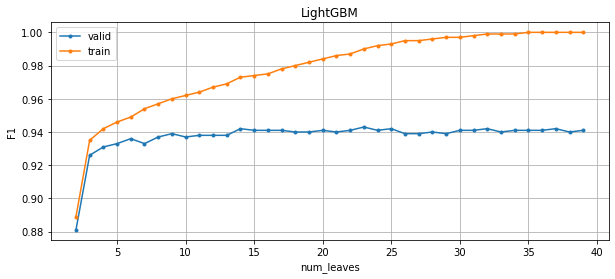

Best valid score: 0.943
Train score: 1.0
Best params: {'num_leaves': 23}


In [159]:
model = lgb.LGBMClassifier(boosting_type='gbdt', random_state=123)
params = {'num_leaves': range(2,40)}
paramCV(model, train_data, params, name='LightGBM')

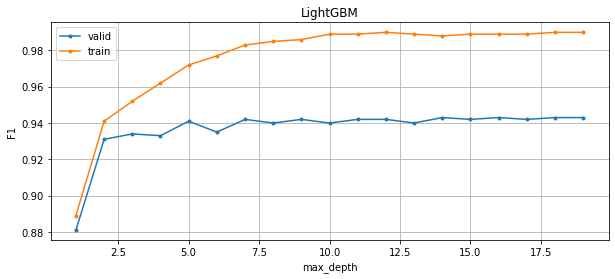

Best valid score: 0.943
Train score: 0.99
Best params: {'max_depth': 14}


In [160]:
model = lgb.LGBMClassifier(boosting_type='gbdt', random_state=123,
                           num_leaves=23)
params = {'max_depth': range(1,20)}
paramCV(model, train_data, params, name='LightGBM')

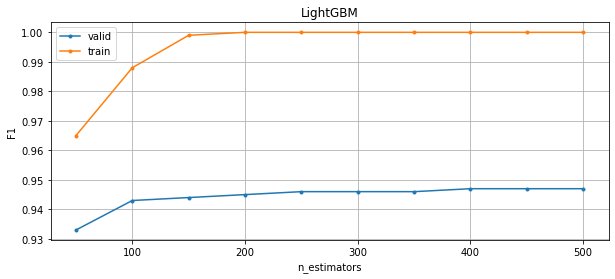

Best valid score: 0.947
Train score: 1.0
Best params: {'n_estimators': 400}


In [161]:
model = lgb.LGBMClassifier(boosting_type='gbdt', random_state=123,
                           num_leaves=23, max_depth=14)
params = {'n_estimators': range(50, 501, 50)}
paramCV(model, train_data, params, name='LightGBM')

### Testing

In [168]:
test_data = pd.read_csv('gym_test0.csv', index_col=0)
print(test_data.info())
test_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1001 to 1200
Data columns (total 11 columns):
Registration                    200 non-null int64
Zipcode                         200 non-null int64
Age                             200 non-null int64
Partner_company                 200 non-null int64
Friend_promo                    200 non-null int64
Contract_period                 200 non-null int64
Lifetime                        200 non-null int64
Class_registration_weekly       200 non-null float64
Avg_additional_charges_total    200 non-null float64
Cancellation_freq               200 non-null float64
Exited                          0 non-null float64
dtypes: float64(4), int64(7)
memory usage: 18.8 KB
None


,Registration,Zipcode,Age,Partner_company,Friend_promo,Contract_period,Lifetime,Class_registration_weekly,Avg_additional_charges_total,Cancellation_freq,Exited
Row,,,,,,,,,,,
1001,2006682,29941,36,0,1,6,2,0.72,225.666667,0.01,NaN
1002,2008504,57328,37,1,0,12,8,1.29,166.666667,0.11,NaN
1003,2020638,33726,50,1,1,1,2,1.18,101.430000,0.12,NaN
1004,2021568,29941,38,0,1,12,5,0.13,215.000000,0.00,NaN
1005,2028557,33726,28,0,1,12,11,1.25,160.720000,0.13,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1196,2975983,57328,34,1,0,1,3,3.29,188.000000,0.12,NaN
1197,2976461,57328,46,0,1,12,9,0.93,205.000000,0.00,NaN
1198,2985140,29941,33,0,0,1,2,1.52,65.450000,0.30,NaN


In [169]:
y_train = data['Exited']
X_train = data.drop(['Exited', 'Unnamed: 12', 'Registration', 'Zipcode'], axis=1)
X_test = test_data.drop(['Exited', 'Registration', 'Zipcode'], axis=1)

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

model = lgb.LGBMClassifier(boosting_type='gbdt', random_state=123, 
                           num_leaves=23, max_depth=14,
                           n_estimators=400)

model.fit(X_train, y_train)
test_predict = model.predict(X_test)
test_data['Exited'] = test_predict
test_data

,Registration,Zipcode,Age,Partner_company,Friend_promo,Contract_period,Lifetime,Class_registration_weekly,Avg_additional_charges_total,Cancellation_freq,Exited
Row,,,,,,,,,,,
1001,2006682,29941,36,0,1,6,2,0.72,225.666667,0.01,0
1002,2008504,57328,37,1,0,12,8,1.29,166.666667,0.11,0
1003,2020638,33726,50,1,1,1,2,1.18,101.430000,0.12,1
1004,2021568,29941,38,0,1,12,5,0.13,215.000000,0.00,0
1005,2028557,33726,28,0,1,12,11,1.25,160.720000,0.13,0
...,...,...,...,...,...,...,...,...,...,...,...
1196,2975983,57328,34,1,0,1,3,3.29,188.000000,0.12,0
1197,2976461,57328,46,0,1,12,9,0.93,205.000000,0.00,0
1198,2985140,29941,33,0,0,1,2,1.52,65.450000,0.30,1


In [170]:
test_data.to_csv('gym_test.csv')